In [ ]:
# %%

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from sim_modules.oct_refocus import (
    forward_refocus_filter, isam_resampling_points, isam
)
from sim_modules.pupils import AberratedPupil3D
from sim_modules.aperture import Aperture
from sim_modules import plottings
from sim_modules.plottings import (
    plot_axial_psf,
    plot_psf_xl,
    plot_psf_yl,
    plot_psf_xy,
    plot_psf_xy_3d,
    plot_psfs_power,
    plot_psfs_xl,
    plot_psfs_yl,
    PSFDict,
    HORIZONTAL_FREQ_LABEL,
    VERTICAL_FREQ_LABEL,
    OPL_LABEL,
    plot_2Dpupil,
    plot_3Dpupil,
    plot_wavefronterror
)
plt.rcParams['text.usetex'] = True

In [ ]:
# %%

# Imaging mode
IMG_MODE = 'PSFD'
# IMG_MODE = 'LF'
# IMG_MODE = 'SCFF'

In [ ]:
# %%

# Refractive index of the surrounding medium
# nb = 1.0  # Refractive index of air
nb = 1.34  # Refractive index of tissue

In [ ]:
# %%

# Flag normalization of pupils
NORMALIZE = True
# NORMALIZE = False

In [ ]:
# %%

# Flag paraxial propagation
PARAXIAL = False  # Simulation with paraxial propagation

In [ ]:
# %%

# Spectral dimension

k_num = 301
k = np.linspace(
    2 * np.pi / 1.26,
    2 * np.pi / 0.90,
    # 2 * np.pi / 0.988,
    # 2 * np.pi / 0.713,
    # 2 * np.pi / 1.060,
    # 2 * np.pi / 0.695,
    num=k_num,
    dtype=np.float32
)
kc = (k[-1] + k[0]) / 2
Δk = (k[-1] - k[0]) / 2

# in tissue
kb = k * nb
kbc = kc * nb
Δkb = Δk * nb

# Single-path optical path length
l = sp.fft.fftshift(sp.fft.fftfreq(k_num, (kb[1] - kb[0]) / (2 * np.pi))) / 2

print("Central wavelength [um]: {}".format(2 * np.pi / kc))
print("Axial range [um]: {}".format((l.max() - l.min()) / nb))
print("Axial res [um]: {}".format(8/Δkb))
print("FWHM wavelength width [nm]: {}".format(
    2 * np.pi / kc ** 2 * Δk * np.sqrt(np.log(2) / 2) * 1e3
))

Central wavelength [um]: 1.0500000185924125
Axial range [um]: 262.29084279997795
Axial res [um]: 5.986126800789171
FWHM wavelength width [nm]: 103.02337058487136


Text(0, 0.5, 'Spectral density [a.u.]')

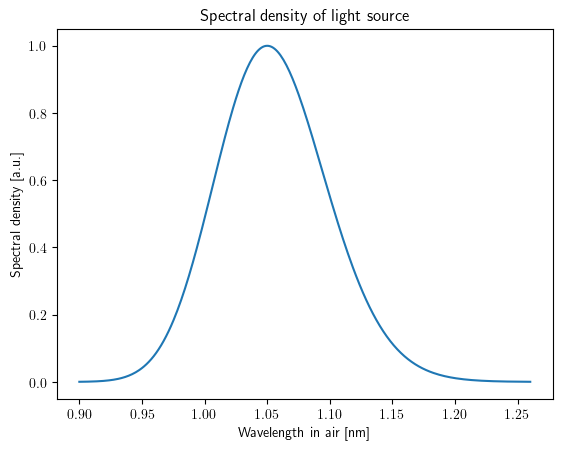

In [ ]:
# %%

# Spectrum
s_k = np.exp(- 8 * (kb - kbc) ** 2 / (Δkb ** 2))

plt.plot(2 * np.pi / k, s_k)
plt.title("Spectral density of light source")
plt.xlabel("Wavelength in air [nm]")
plt.ylabel("Spectral density [a.u.]")

In [ ]:
# %%

# Wavefront aberration parameters
# NOTE: The wavefront aberration simulation is now available for the same cut-off NA and
# the shared optical path between the illumination and collection.
#
# If the paths are shared but have different cutoff NAs, scaling of the Zernike expansion would be necessary.
#
# In the case of the different optical path, the wavefront aberration should be defined separately.

ns = [(2, 2), (3, 1), (3, 3), (4, 0)]  # Zernike expansion orders
coeff = [(0.2, -0.05), (0.04, -0.032), (0.0, 0.0), -0.1]  # Zernike expansion coefficients (RMS) [µm]

In [ ]:
# %%

# Chromatic aberrations
Δx = 0.0  # Transversal focal shift amount per bandwidth [µm]
Δz = 0.0  # Longitudinal focal shift amount per bandwidth [µm]

ca = (Δx / Δkb, 0, Δz / Δkb)

In [ ]:
# %%

# Size parameters of pupil, NA in air
if IMG_MODE == 'SCFF':
    na_co_ill = 0.0
    na_w_ill = 0.0
else:
    pupil_ill = AberratedPupil3D('Hann', 0.25, ns, coeff, ca=ca, kc=kbc)

pupil_col = AberratedPupil3D('Hann', 0.25, ns, coeff, ca=ca, kc=kbc)

In [ ]:
# %%

# Pupil coordinates
νpx_num = 257
# νpx_num = 501

if np.isscalar(pupil_ill.na_co):
    na_co_ill_max = pupil_ill.na_co
else:
    na_co_ill_max = max(pupil_ill.na_co)

if np.isscalar(pupil_col.na_co):
    na_co_col_max = pupil_col.na_co
else:
    na_co_col_max = max(pupil_col.na_co)

νx_max = (kb.max() / (2 * np.pi)) * max(na_co_ill_max, na_co_col_max)
νpx, νpy = np.meshgrid(
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    indexing='xy'
)

dνx = dνy = νpx[0, 1] - νpx[0, 0]

In [ ]:
# %%

# Spatial frequency coordinates for the illumination pupil
match IMG_MODE:
    case 'PSFD':
        νx_ill = νpx
        νy_ill = νpy
    case 'LF':
        νx_ill = νpx[None, 0]
        νy_ill = np.zeros_like(νx_ill)

In [ ]:
# %%

# Pupil coordinates for the central wavelength
σxc_ill = - 2 * np.pi * νx_ill / kbc
σyc_ill = - 2 * np.pi * νy_ill / kbc
σxc_col = - 2 * np.pi * νpx / kbc
σyc_col = - 2 * np.pi * νpy / kbc

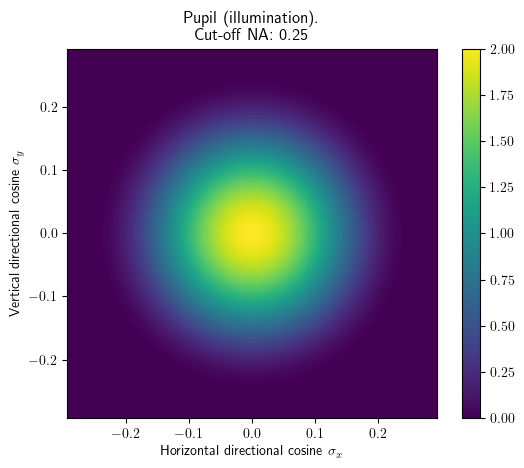

In [ ]:
# %%

# 2D plot of the illumination pupil
if IMG_MODE != 'SCFF':

    plot_2Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

c:\Local\Makita\Dropbox\GitHub\COG-OCTPSF-simulator\sim_modules\plottings.py:551: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


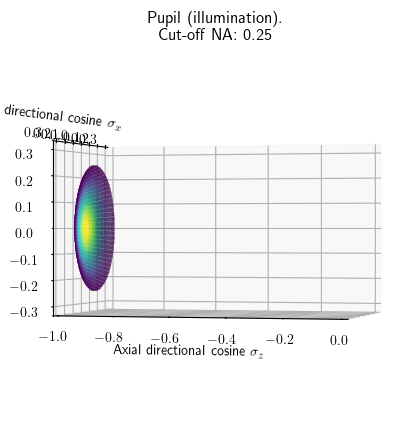

In [ ]:
# %%

# 3D surface plot of the illumination pupil
if IMG_MODE == 'PSFD':
    plot_3Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

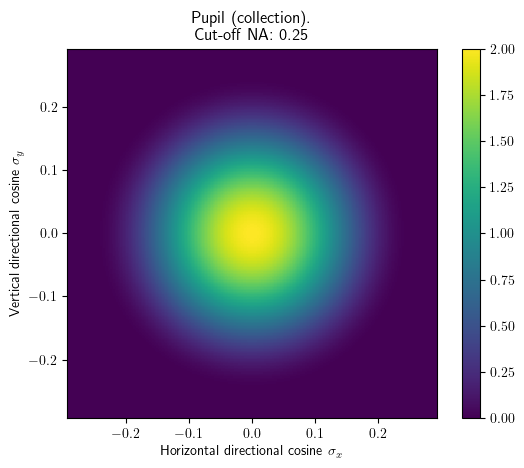

In [ ]:
# %%

# 2D plot of the collection pupil

plot_2Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

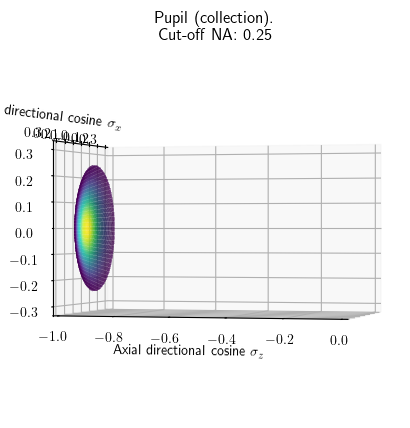

In [ ]:
# %%

# 3D surface plot of the collection pupil
plot_3Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

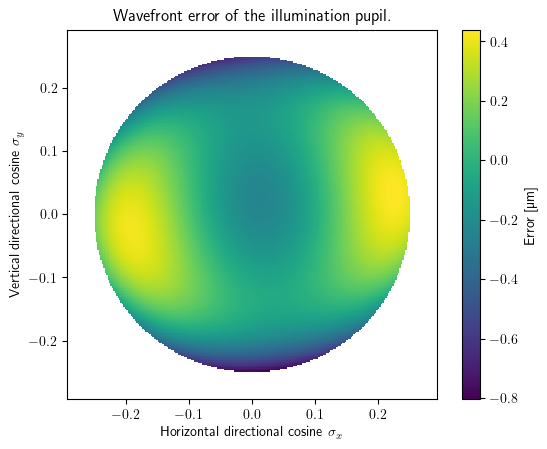

In [ ]:
# %%

# 2D plot of wavefront error in illumination pupil
plot_wavefronterror(
    pupil_ill,
    σxc_ill,
    σyc_ill,
    'illumination'
)

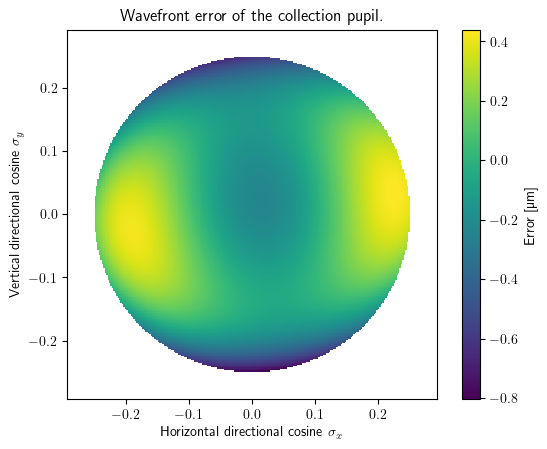

In [ ]:
# %%

# 2D plot of wavefront error in collection pupil
plot_wavefronterror(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

In [ ]:
# %%

# Spatial coordinate
match IMG_MODE:
    case 'SCFF':
        νx_num = νpx_num
        νy_num = νpx_num
    case 'PSFD':
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num * 2 - 1  # Doubled to take into account convolution
    case 'LF':
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num
y = sp.fft.fftshift(sp.fft.fftfreq(νy_num, (νpy[1, 0] - νpy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(νx_num, (νpx[0, 1] - νpx[0, 0])))

print(x.max() - x.min())

343.20963915806476


In [ ]:
# %%

# Spatial frequency coordinates for the aperture
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# %%

# Axial location
z0 = 0.0  # Axial position of the focal plane

# Scatterers' locations
zs = np.array([0., 100., 200., -100., -200.], dtype=np.float32)
z = z0 - zs
idx_zs0 = np.where(zs == 0)[0][0]
idx_z0 = np.where((z0 - zs) == 0)[0][0]

In [ ]:
# %%

# Initialize, allocate memory

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

aperture = Aperture(pupil_ill, pupil_col, IMG_MODE)

h_tilde.nbytes / 1024 ** 2

3021.7692947387695

In [ ]:
# %%

for i, kb_i in enumerate(kb):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z, NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL)

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

In [ ]:
# %%

# Apply phase shift of propagation to the focal plane
h_tilde = h_tilde * np.exp(1j * kb * 2 * z0)[None, None, None, :]

In [ ]:
# %%

plottings.display_gamma = 1.0

In [ ]:
# %%

# complex point-spread function
# FFT k -> z

SF_MODE = 'PSF'
# SF_MODE = 'LSF'

x12 = [-50.0, 50.0]
xd_num = 129

lw = 30.0 * 2
ld_num = 65

psf = np.zeros((xd_num, xd_num, z.size, ld_num), dtype=np.complex64)
h_OCT = np.zeros((νy_num, νx_num, z.size, ld_num), dtype=np.complex64)
xd = np.linspace(x12[0], x12[1], num=xd_num, endpoint=True)
ld = np.zeros((ld_num, z.size), dtype=np.float32)  # single-trip OPL

for i in range(z.size):
    l12 = [nb * zs[i] * 2 - lw / 2, nb * zs[i] * 2 + lw / 2]

    h_OCT[..., i, :] = sp.signal.zoom_fft(
            (s_k * (kb ** 2) / (4 * np.pi))[None, None, :]
            * h_tilde[..., i, :],
            l12,
            fs=(2 * np.pi)/(k[1] - k[0]),
            m=ld_num,
            axis=-1
        ) * (k[1] - k[0]) / (2 * np.pi)

    if SF_MODE == 'PSF':
        psf[..., i, :] = sp.signal.zoom_fft(
            sp.signal.zoom_fft(
                h_OCT[..., i, :], x12, fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, fs=1/dνy, m=xd_num, axis=0
        ) * dνy
    elif SF_MODE == 'LSF':
        # Layer-spread function
        # This corresponds to the common axial PSF measurements in OCT.
        # The sample is assumed to be a reflective plane, such as a mirror.
        psf[..., i, :] = sp.signal.zoom_fft(
            sp.signal.zoom_fft(
                h_OCT[νy_num // 2, νx_num // 2, None, None, i, :],
                x12, fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, fs=1/dνy, m=xd_num, axis=0
        ) * dνy

    ld[..., i] = np.linspace(l12[0], l12[1], num=ld_num, endpoint=True) / 2

psf_dict = PSFDict()
psf_dict.update(
    {'psf': psf, 'x': xd, 'defocus': -z, 'opl': ld,
        'desc': 'Raw', 'MODE': IMG_MODE}
)

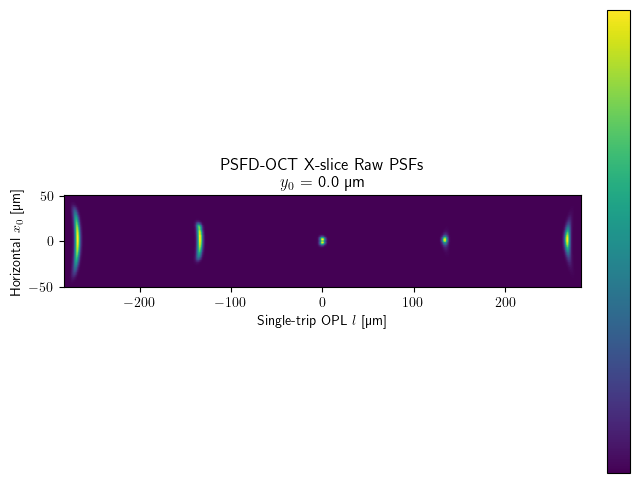

In [ ]:
# %%

plot_psfs_xl(psf_dict)

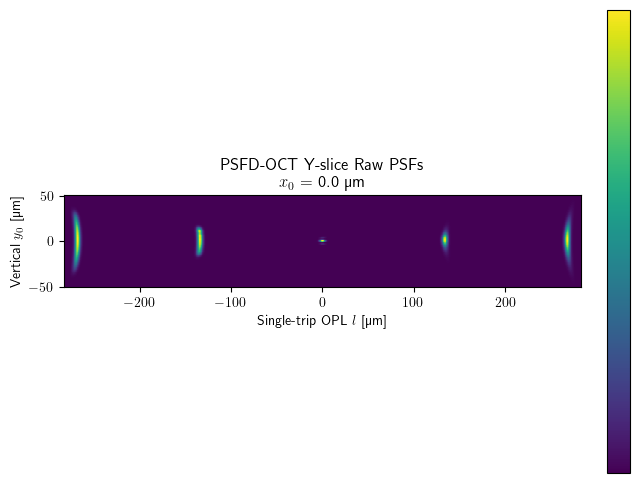

In [ ]:
# %%

plot_psfs_yl(psf_dict)

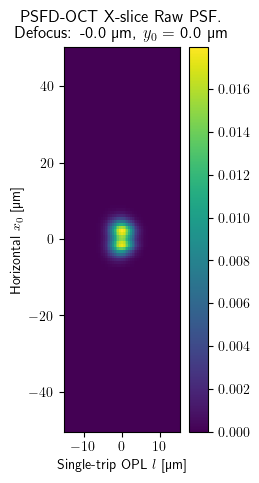

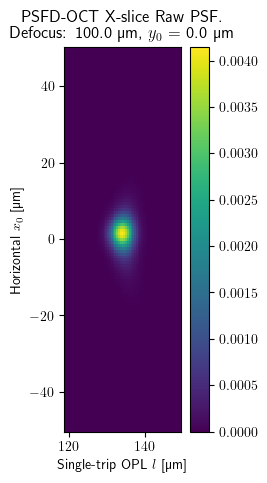

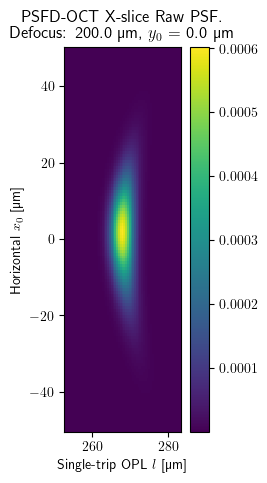

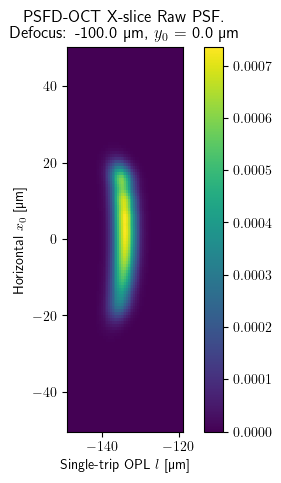

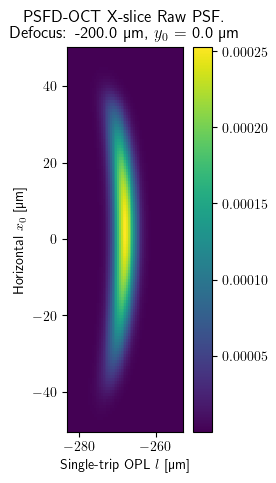

In [ ]:
# %%

for i in range(zs.size):
    plot_psf_xl(psf_dict, i=i, show_FWHM=False)

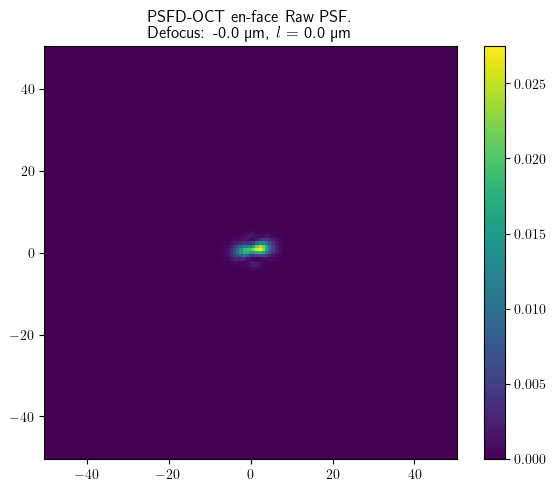

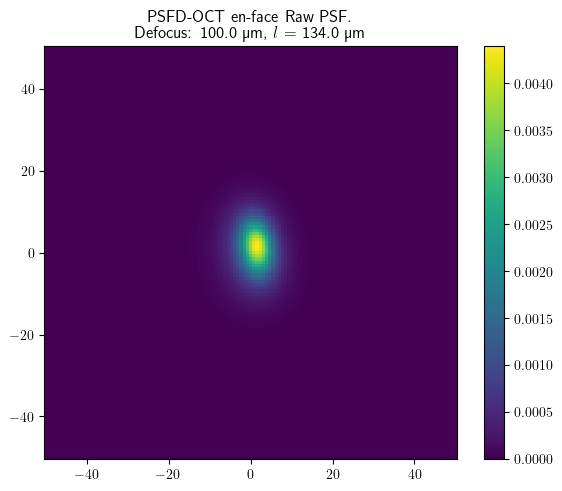

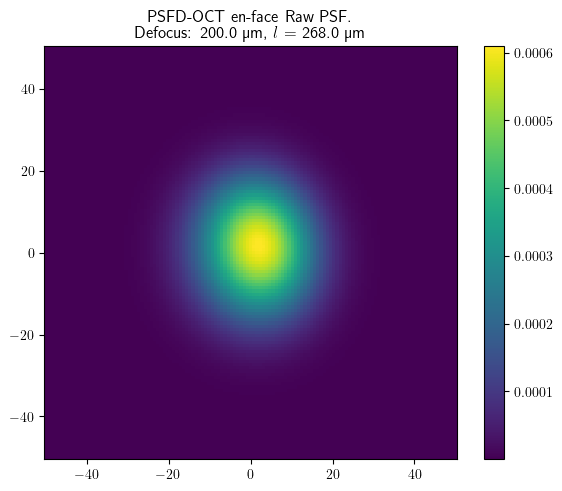

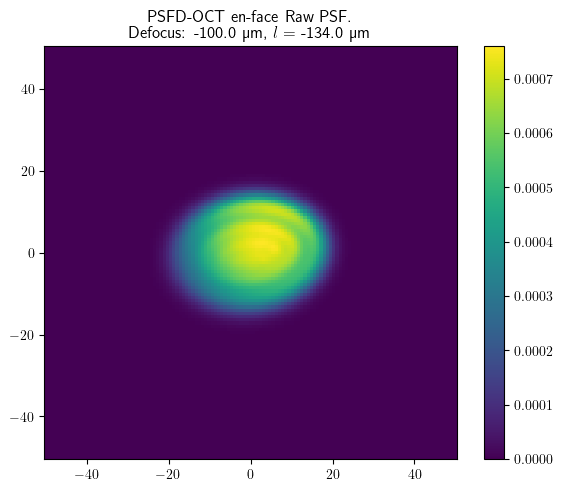

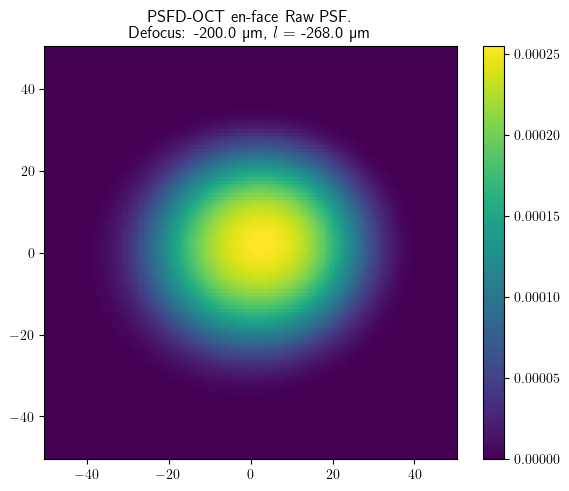

In [ ]:
# %%

for i in range(zs.size):
    plot_psf_xy(psf_dict, i=i, num=None, l_i_s=0, show_FWHM=False)